# Semestrálna práca

Ako semestrálnu prácu som si vybral klasifikáciu obrazových dát pomocou obyčajnej doprednej a konvolučnej siete a ich porovnanie na CIFAR-10 datasete (https://www.cs.toronto.edu/~kriz/cifar.html).

In [109]:
import numpy as np
import math
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import sklearn
import pickle
import urllib.request
import tarfile
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import tensorflow_addons as tfa
import pandas as pd

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.0


## Informácie o datasete

Najprv si stiahneme želaný dataset a definujeme preň lable

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Zobrazíme si vzorky z trénovacieho datasetu spolu s príslušnými labelmi

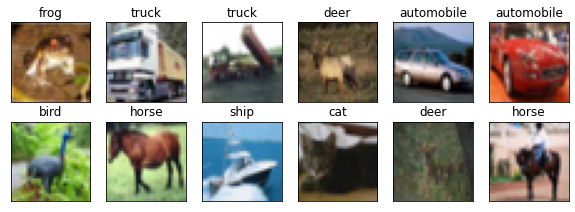

In [4]:
plt.figure(figsize=(10, 7))
for i in range(12):
    plt.subplot(4, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap = plt.cm.bone)
    plt.title(class_labels[Y_train[i][0]])

In [5]:
print("Train shape:", X_train.shape)
print("Train label shape:", Y_train.shape)
print("Test shape:", X_test.shape)
print("Test label shape:", Y_test.shape)

Train shape: (50000, 32, 32, 3)
Train label shape: (50000, 1)
Test shape: (10000, 32, 32, 3)
Test label shape: (10000, 1)


In [6]:
print(f'V trénovacom datasete sa nachádza {X_train.shape[0]} obrázkov, s rozmermi {X_train.shape[1]}x{X_train.shape[2]} a s {X_train.shape[3]} zložkami.')
print(f'V testovacom datasete sa nachádza {X_test.shape[0]} obrázkov, s rozmermi {X_test.shape[1]}x{X_test.shape[2]} a s {X_test.shape[3]} zložkami.')

V trénovacom datasete sa nachádza 50000 obrázkov, s rozmermi 32x32 a s 3 zložkami.
V testovacom datasete sa nachádza 10000 obrázkov, s rozmermi 32x32 a s 3 zložkami.


##### Normalizujeme si hodnoty pixelov do intervalu [0, 1]:

In [7]:
X_train = X_train / 255
X_test = X_test / 255

## ANN

Hyperparametre pre obyčajnú doprednú a CNN sieť budeme hľadať pomocou metódy `grid_search`, ktorej argumenty sú definované parametre s ich hodnotami, ktoré chceme postupne testovať. Následne vrátime model s takou kombináciou hyperparametrov, ktoré nám vrátia model s najlepšou presnosťou.

In [8]:
def grid_search(model, grid_search_params):
    model_wrapper = KerasClassifier(build_fn = model, verbose = 1)
    grid = GridSearchCV(estimator = model_wrapper, param_grid = grid_search_params, refit = False)
    grid_search_result = grid.fit(X_train, Y_train, validation_data = (X_test, Y_test))
    return grid_search_result

Metóda vracajúca model, ktorý bude slúžiť ako "base model" voči ostatným CNN sieťam.

In [9]:
def build_base_model(neurons = 1, metrics = 'accuracy'):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape = X_train.shape[1:]))
    model.add(tf.keras.layers.Dense(neurons, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dense(neurons, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))
    
    model.compile(
        optimizer = tf.optimizers.SGD(),
        loss = tf.losses.SparseCategoricalCrossentropy(),
        metrics = [metrics] # tf.metrics.SparseCategoricalAccuracy()
    )
    
    return model

Definujeme si funkciu `show_confusion_matrix`, ktorá nám zobrazí maticu zámen na základe reálnych a predikovaných labelov pre obrázky z datesetu

In [10]:
def show_confusion_matrix(real, predicted, labels):
    cm = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_true = real, y_pred = predicted, normalize = 'true'), display_labels = labels)
    fig, ax = plt.subplots(figsize=(12,12))
    cm.plot(ax=ax)

Ešte si definujeme funkciu `show_images_with_predicted_labels`, ktorá nám zobrazí obrázky spolu s predikovanými labelmi

In [11]:
def show_images_with_predicted_labels(images, predicted_labels):
    plt.figure(figsize=(10, 7))
    for i in range(24):
        plt.subplot(4, 6, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap = plt.cm.bone)
        plt.title(class_labels[predicted_labels[i]])

Najprv si pomocou Grid Searchu nájdeme vhodný počet neurónov pre každú skrytú vrstvu ANN siete a batch size. Vrátené hyperparametre z Grid Searchu nám neskôr poslúžia pre vytvorenie "base modelu", voči ktorému budeme porovnávať iné architektúry sietí.

In [12]:
ann_gs = grid_search(build_base_model, dict(neurons=[128, 256, 512], batch_size=[16, 32, 64, 128]))

/var/folders/x8/bld_jpn12sgcxmqz5t3y6wb80000gn/T/ipykernel_87136/3117033963.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model_wrapper = KerasClassifier(build_fn = model, verbose = 1)
2022-06-21 18:07:06.874723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-21 18:07:06.874841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


2022-06-21 18:07:07.393152: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-21 18:07:07.550738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2494/2500 [============================>.] - ETA: 0s - loss: 1.8890 - accuracy: 0.3153

2022-06-21 18:07:18.084515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 39/625 [>.............................] - ETA: 2s - loss: 1.7093 - accuracy: 0.3798

2022-06-21 18:07:20.008482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  25/2500 [..............................] - ETA: 10s - loss: 2.3040 - accuracy: 0.1525

2022-06-21 18:07:24.086825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2496/2500 [============================>.] - ETA: 0s - loss: 1.8842 - accuracy: 0.3183

2022-06-21 18:07:34.722734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 37/625 [>.............................] - ETA: 2s - loss: 1.8336 - accuracy: 0.3530

2022-06-21 18:07:36.734144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  24/2500 [..............................] - ETA: 11s - loss: 2.3083 - accuracy: 0.1172

2022-06-21 18:07:40.923076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2488/2500 [============================>.] - ETA: 0s - loss: 1.8910 - accuracy: 0.3154

2022-06-21 18:07:51.759897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 23/625 [>.............................] - ETA: 2s - loss: 1.7459 - accuracy: 0.3777

2022-06-21 18:07:54.075580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  24/2500 [..............................] - ETA: 11s - loss: 2.3307 - accuracy: 0.1354    

2022-06-21 18:07:58.439894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2496/2500 [============================>.] - ETA: 0s - loss: 1.8827 - accuracy: 0.3181

2022-06-21 18:08:09.848074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 36/625 [>.............................] - ETA: 2s - loss: 1.7770 - accuracy: 0.3472

2022-06-21 18:08:11.949918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  26/2500 [..............................] - ETA: 10s - loss: 2.3210 - accuracy: 0.1106

2022-06-21 18:08:16.419843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2491/2500 [============================>.] - ETA: 0s - loss: 1.8866 - accuracy: 0.3192

2022-06-21 18:08:27.112999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 36/625 [>.............................] - ETA: 2s - loss: 1.7415 - accuracy: 0.3993

2022-06-21 18:08:29.246352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  24/2500 [..............................] - ETA: 11s - loss: 2.3087 - accuracy: 0.1693    

2022-06-21 18:08:33.308235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2499/2500 [============================>.] - ETA: 0s - loss: 1.8670 - accuracy: 0.3263

2022-06-21 18:08:43.914118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 37/625 [>.............................] - ETA: 2s - loss: 1.7006 - accuracy: 0.3514

2022-06-21 18:08:45.877794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  24/2500 [..............................] - ETA: 11s - loss: 2.3290 - accuracy: 0.1250

2022-06-21 18:08:50.070338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2492/2500 [============================>.] - ETA: 0s - loss: 1.8594 - accuracy: 0.3322

2022-06-21 18:09:02.092123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 39/625 [>.............................] - ETA: 2s - loss: 1.8340 - accuracy: 0.3590

2022-06-21 18:09:04.152641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  24/2500 [..............................] - ETA: 11s - loss: 2.3339 - accuracy: 0.1224

2022-06-21 18:09:08.549094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - ETA: 0s - loss: 1.8680 - accuracy: 0.3282

2022-06-21 18:09:19.146564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 35/625 [>.............................] - ETA: 2s - loss: 1.7410 - accuracy: 0.3893

2022-06-21 18:09:21.211952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  25/2500 [..............................] - ETA: 10s - loss: 2.3293 - accuracy: 0.1100    

2022-06-21 18:09:25.148622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2498/2500 [============================>.] - ETA: 0s - loss: 1.8570 - accuracy: 0.3266

2022-06-21 18:09:35.808286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 26/625 [>.............................] - ETA: 2s - loss: 1.7137 - accuracy: 0.3630

2022-06-21 18:09:37.840587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  25/2500 [..............................] - ETA: 11s - loss: 2.3661 - accuracy: 0.0950

2022-06-21 18:09:41.880199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2490/2500 [============================>.] - ETA: 0s - loss: 1.8606 - accuracy: 0.3304

2022-06-21 18:09:52.507463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 42/625 [=>............................] - ETA: 2s - loss: 1.7375 - accuracy: 0.3839

2022-06-21 18:09:54.587316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  24/2500 [..............................] - ETA: 11s - loss: 2.3381 - accuracy: 0.1354

2022-06-21 18:09:59.533824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2491/2500 [============================>.] - ETA: 0s - loss: 1.8531 - accuracy: 0.3332

2022-06-21 18:10:12.344124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 40/625 [>.............................] - ETA: 2s - loss: 1.6926 - accuracy: 0.3812

2022-06-21 18:10:14.531483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  28/2500 [..............................] - ETA: 9s - loss: 2.3013 - accuracy: 0.1339 

2022-06-21 18:10:18.586203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2499/2500 [============================>.] - ETA: 0s - loss: 1.8445 - accuracy: 0.3378

2022-06-21 18:10:29.314671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 41/625 [>.............................] - ETA: 2s - loss: 1.7913 - accuracy: 0.3811

2022-06-21 18:10:31.348378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  25/2500 [..............................] - ETA: 10s - loss: 2.3236 - accuracy: 0.1250    

2022-06-21 18:10:34.648342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2495/2500 [============================>.] - ETA: 0s - loss: 1.8575 - accuracy: 0.3306

2022-06-21 18:10:46.006193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 40/625 [>.............................] - ETA: 2s - loss: 1.7190 - accuracy: 0.3688

2022-06-21 18:10:48.265673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  24/2500 [..............................] - ETA: 11s - loss: 2.3276 - accuracy: 0.1380

2022-06-21 18:10:51.785943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2488/2500 [============================>.] - ETA: 0s - loss: 1.8481 - accuracy: 0.3354

2022-06-21 18:11:02.385463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 41/625 [>.............................] - ETA: 2s - loss: 1.7330 - accuracy: 0.3720

2022-06-21 18:11:04.390280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  25/2500 [..............................] - ETA: 10s - loss: 2.3337 - accuracy: 0.1250    

2022-06-21 18:11:07.447889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2497/2500 [============================>.] - ETA: 0s - loss: 1.8444 - accuracy: 0.3382

2022-06-21 18:11:18.012120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 42/625 [=>............................] - ETA: 2s - loss: 1.7083 - accuracy: 0.4167

2022-06-21 18:11:20.216523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  23/1250 [..............................] - ETA: 5s - loss: 2.3060 - accuracy: 0.1386

2022-06-21 18:11:24.198318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 1.9392 - accuracy: 0.3013

2022-06-21 18:11:29.363032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 21/313 [=>............................] - ETA: 1s - loss: 1.7974 - accuracy: 0.3438

2022-06-21 18:11:30.875489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  22/1250 [..............................] - ETA: 5s - loss: 2.3121 - accuracy: 0.1151

2022-06-21 18:11:34.493551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1239/1250 [============================>.] - ETA: 0s - loss: 1.9283 - accuracy: 0.3074

2022-06-21 18:11:40.704200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20/313 [>.............................] - ETA: 1s - loss: 1.9304 - accuracy: 0.3156

2022-06-21 18:11:42.128338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  26/1250 [..............................] - ETA: 4s - loss: 2.3074 - accuracy: 0.1238

2022-06-21 18:11:46.405695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 1.9393 - accuracy: 0.2980

2022-06-21 18:11:51.762367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 7s 5ms/step - loss: 1.9391 - accuracy: 0.2980 - val_loss: 1.8149 - val_accuracy: 0.3432


2022-06-21 18:11:53.249015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  25/1250 [..............................] - ETA: 5s - loss: 2.2925 - accuracy: 0.1412

2022-06-21 18:11:57.389587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1243/1250 [============================>.] - ETA: 0s - loss: 1.9328 - accuracy: 0.3020

2022-06-21 18:12:02.662498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 24/313 [=>............................] - ETA: 1s - loss: 1.8562 - accuracy: 0.3125

2022-06-21 18:12:04.216448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  27/1250 [..............................] - ETA: 4s - loss: 2.3018 - accuracy: 0.1204

2022-06-21 18:12:08.281568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1241/1250 [============================>.] - ETA: 0s - loss: 1.9278 - accuracy: 0.3039

2022-06-21 18:12:14.132996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 17/313 [>.............................] - ETA: 1s - loss: 1.8470 - accuracy: 0.3824

2022-06-21 18:12:15.574426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  26/1250 [..............................] - ETA: 5s - loss: 2.3149 - accuracy: 0.1202

2022-06-21 18:12:19.995912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1240/1250 [============================>.] - ETA: 0s - loss: 1.9084 - accuracy: 0.3174

2022-06-21 18:12:25.635136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 36/313 [==>...........................] - ETA: 1s - loss: 1.7157 - accuracy: 0.3793

2022-06-21 18:12:26.905131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  26/1250 [..............................] - ETA: 5s - loss: 2.3107 - accuracy: 0.1178

2022-06-21 18:12:29.813932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 1.8985 - accuracy: 0.3158

2022-06-21 18:12:36.702264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 23/313 [=>............................] - ETA: 1s - loss: 1.8320 - accuracy: 0.3804

2022-06-21 18:12:37.994594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  27/1250 [..............................] - ETA: 4s - loss: 2.2983 - accuracy: 0.1412

2022-06-21 18:12:40.040567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 1.9073 - accuracy: 0.3156

2022-06-21 18:12:45.493333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 36/313 [==>...........................] - ETA: 1s - loss: 1.7839 - accuracy: 0.3628

2022-06-21 18:12:46.807305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  26/1250 [..............................] - ETA: 5s - loss: 2.3135 - accuracy: 0.1310

2022-06-21 18:12:49.641984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1247/1250 [============================>.] - ETA: 0s - loss: 1.9029 - accuracy: 0.3166

2022-06-21 18:12:54.885545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 15/313 [>.............................] - ETA: 2s - loss: 1.7564 - accuracy: 0.3750

2022-06-21 18:12:56.628441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  23/1250 [..............................] - ETA: 5s - loss: 2.3034 - accuracy: 0.1236

2022-06-21 18:12:59.870341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1241/1250 [============================>.] - ETA: 0s - loss: 1.8978 - accuracy: 0.3172

2022-06-21 18:13:05.276676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 36/313 [==>...........................] - ETA: 1s - loss: 1.8668 - accuracy: 0.3507

2022-06-21 18:13:06.854863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  24/1250 [..............................] - ETA: 5s - loss: 2.2961 - accuracy: 0.1510

2022-06-21 18:13:10.728409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1247/1250 [============================>.] - ETA: 0s - loss: 1.8880 - accuracy: 0.3242

2022-06-21 18:13:17.083506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 24/313 [=>............................] - ETA: 1s - loss: 1.7158 - accuracy: 0.3867

2022-06-21 18:13:18.489351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  23/1250 [..............................] - ETA: 5s - loss: 2.2930 - accuracy: 0.1250

2022-06-21 18:13:22.430750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 1.8849 - accuracy: 0.3235

2022-06-21 18:13:28.539528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 25/313 [=>............................] - ETA: 1s - loss: 1.7938 - accuracy: 0.3725

2022-06-21 18:13:30.225596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  22/1250 [..............................] - ETA: 6s - loss: 2.2896 - accuracy: 0.1236

2022-06-21 18:13:34.405235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1243/1250 [============================>.] - ETA: 0s - loss: 1.8921 - accuracy: 0.3224

2022-06-21 18:13:40.236188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 12/313 [>.............................] - ETA: 2s - loss: 1.7514 - accuracy: 0.3776

2022-06-21 18:13:42.312155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  23/1250 [..............................] - ETA: 5s - loss: 2.3033 - accuracy: 0.1495

2022-06-21 18:13:46.889153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1247/1250 [============================>.] - ETA: 0s - loss: 1.8870 - accuracy: 0.3229

2022-06-21 18:13:52.573525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20/313 [>.............................] - ETA: 1s - loss: 1.7417 - accuracy: 0.3812

2022-06-21 18:13:54.028755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  24/1250 [..............................] - ETA: 5s - loss: 2.2875 - accuracy: 0.1576

2022-06-21 18:13:58.010076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1243/1250 [============================>.] - ETA: 0s - loss: 1.8855 - accuracy: 0.3258

2022-06-21 18:14:03.599201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 23/313 [=>............................] - ETA: 1s - loss: 1.7751 - accuracy: 0.3709

2022-06-21 18:14:04.973229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 10/625 [..............................] - ETA: 3s - loss: 2.3523 - accuracy: 0.1078  

2022-06-21 18:14:08.489435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


620/625 [============================>.] - ETA: 0s - loss: 1.9969 - accuracy: 0.2809

2022-06-21 18:14:12.206022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 22/157 [===>..........................] - ETA: 0s - loss: 1.8326 - accuracy: 0.3288

2022-06-21 18:14:13.268026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 25/625 [>.............................] - ETA: 2s - loss: 2.2979 - accuracy: 0.1400

2022-06-21 18:14:15.753259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


624/625 [============================>.] - ETA: 0s - loss: 1.9928 - accuracy: 0.2825

2022-06-21 18:14:18.623947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 24/157 [===>..........................] - ETA: 0s - loss: 1.8706 - accuracy: 0.3535

2022-06-21 18:14:19.657839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 28/625 [>.............................] - ETA: 2s - loss: 2.2993 - accuracy: 0.1356 

2022-06-21 18:14:23.132279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


612/625 [============================>.] - ETA: 0s - loss: 2.0010 - accuracy: 0.2802

2022-06-21 18:14:25.609894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 37/157 [======>.......................] - ETA: 0s - loss: 1.8469 - accuracy: 0.3488

2022-06-21 18:14:26.314937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 23/625 [>.............................] - ETA: 2s - loss: 2.3047 - accuracy: 0.1277

2022-06-21 18:14:27.734378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


613/625 [============================>.] - ETA: 0s - loss: 1.9954 - accuracy: 0.2818

2022-06-21 18:14:30.788626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 30/157 [====>.........................] - ETA: 0s - loss: 1.8774 - accuracy: 0.3401

2022-06-21 18:14:31.553392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 22/625 [>.............................] - ETA: 2s - loss: 2.3055 - accuracy: 0.1257

2022-06-21 18:14:32.871202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


613/625 [============================>.] - ETA: 0s - loss: 1.9978 - accuracy: 0.2823

2022-06-21 18:14:35.817008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 21/157 [===>..........................] - ETA: 0s - loss: 1.9082 - accuracy: 0.3266

2022-06-21 18:14:36.776440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 25/625 [>.............................] - ETA: 2s - loss: 2.2883 - accuracy: 0.1350

2022-06-21 18:14:39.358573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


618/625 [============================>.] - ETA: 0s - loss: 1.9585 - accuracy: 0.3002

2022-06-21 18:14:42.476438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 25/157 [===>..........................] - ETA: 0s - loss: 1.7875 - accuracy: 0.3731

2022-06-21 18:14:43.364844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 26/625 [>.............................] - ETA: 2s - loss: 2.2831 - accuracy: 0.1418

2022-06-21 18:14:45.708729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


621/625 [============================>.] - ETA: 0s - loss: 1.9502 - accuracy: 0.2996

2022-06-21 18:14:48.905772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 22/157 [===>..........................] - ETA: 0s - loss: 1.8442 - accuracy: 0.3544

2022-06-21 18:14:50.052849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 25/625 [>.............................] - ETA: 2s - loss: 2.2908 - accuracy: 0.1281

2022-06-21 18:14:53.822410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


619/625 [============================>.] - ETA: 0s - loss: 1.9601 - accuracy: 0.2978

2022-06-21 18:14:56.813681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 25/157 [===>..........................] - ETA: 0s - loss: 1.8313 - accuracy: 0.3606

2022-06-21 18:14:57.835695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 26/625 [>.............................] - ETA: 2s - loss: 2.2857 - accuracy: 0.1298

2022-06-21 18:15:00.820350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


616/625 [============================>.] - ETA: 0s - loss: 1.9540 - accuracy: 0.2990

2022-06-21 18:15:04.198172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20/157 [==>...........................] - ETA: 0s - loss: 1.8380 - accuracy: 0.3602

2022-06-21 18:15:04.993124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  6/625 [..............................] - ETA: 6s - loss: 2.3624 - accuracy: 0.0781  

2022-06-21 18:15:08.315998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


619/625 [============================>.] - ETA: 0s - loss: 1.9511 - accuracy: 0.3033

2022-06-21 18:15:11.472089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 25/157 [===>..........................] - ETA: 0s - loss: 1.9824 - accuracy: 0.3094

2022-06-21 18:15:12.400616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 13/625 [..............................] - ETA: 2s - loss: 2.3146 - accuracy: 0.1250  

2022-06-21 18:15:15.530651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


614/625 [============================>.] - ETA: 0s - loss: 1.9430 - accuracy: 0.3067

2022-06-21 18:15:19.169893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 11/157 [=>............................] - ETA: 0s - loss: 1.7582 - accuracy: 0.3807 

2022-06-21 18:15:20.065915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 12/625 [..............................] - ETA: 2s - loss: 2.3155 - accuracy: 0.1263  

2022-06-21 18:15:22.732061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


616/625 [============================>.] - ETA: 0s - loss: 1.9375 - accuracy: 0.3088

2022-06-21 18:15:25.674774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  7/157 [>.............................] - ETA: 1s - loss: 1.8978 - accuracy: 0.3527 

2022-06-21 18:15:26.550927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 25/625 [>.............................] - ETA: 2s - loss: 2.2595 - accuracy: 0.1462

2022-06-21 18:15:29.013632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


617/625 [============================>.] - ETA: 0s - loss: 1.9426 - accuracy: 0.3061

2022-06-21 18:15:31.848295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 23/157 [===>..........................] - ETA: 0s - loss: 1.8132 - accuracy: 0.3607

2022-06-21 18:15:32.714328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 27/625 [>.............................] - ETA: 2s - loss: 2.2665 - accuracy: 0.1678

2022-06-21 18:15:36.104970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


618/625 [============================>.] - ETA: 0s - loss: 1.9374 - accuracy: 0.3101

2022-06-21 18:15:38.554024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 34/157 [=====>........................] - ETA: 0s - loss: 1.8323 - accuracy: 0.3612

2022-06-21 18:15:39.282769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 23/625 [>.............................] - ETA: 2s - loss: 2.2725 - accuracy: 0.1644

2022-06-21 18:15:40.729411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


613/625 [============================>.] - ETA: 0s - loss: 1.9369 - accuracy: 0.3080

2022-06-21 18:15:43.494858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 38/157 [======>.......................] - ETA: 0s - loss: 1.8263 - accuracy: 0.3557

2022-06-21 18:15:44.193136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 22/313 [=>............................] - ETA: 1s - loss: 2.3002 - accuracy: 0.1339

2022-06-21 18:15:45.451095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


308/313 [============================>.] - ETA: 0s - loss: 2.0711 - accuracy: 0.2585

2022-06-21 18:15:47.257521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/79 [====>.........................] - ETA: 0s - loss: 1.9423 - accuracy: 0.3036

2022-06-21 18:15:47.705469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20/313 [>.............................] - ETA: 1s - loss: 2.3024 - accuracy: 0.1441

2022-06-21 18:15:49.766809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/313 [============================>.] - ETA: 0s - loss: 2.0675 - accuracy: 0.2562

2022-06-21 18:15:51.622753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/79 [========>.....................] - ETA: 0s - loss: 1.9961 - accuracy: 0.2754

2022-06-21 18:15:52.412872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20/313 [>.............................] - ETA: 1s - loss: 2.2952 - accuracy: 0.1445

2022-06-21 18:15:55.393413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 2.0726 - accuracy: 0.2555

2022-06-21 18:15:57.335627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/79 [========>.....................] - ETA: 0s - loss: 1.9929 - accuracy: 0.2780

2022-06-21 18:15:58.141693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 21/313 [=>............................] - ETA: 1s - loss: 2.2960 - accuracy: 0.1492

2022-06-21 18:16:01.148360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/313 [============================>.] - ETA: 0s - loss: 2.0646 - accuracy: 0.2602

2022-06-21 18:16:03.124535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/79 [=======>......................] - ETA: 0s - loss: 1.9831 - accuracy: 0.2738

2022-06-21 18:16:03.625798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 10/313 [..............................] - ETA: 1s - loss: 2.3497 - accuracy: 0.1070 

2022-06-21 18:16:06.406449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


309/313 [============================>.] - ETA: 0s - loss: 2.0713 - accuracy: 0.2580

2022-06-21 18:16:08.228750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/79 [========>.....................] - ETA: 0s - loss: 1.9507 - accuracy: 0.3034

2022-06-21 18:16:08.759818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 10/313 [..............................] - ETA: 1s - loss: 2.3235 - accuracy: 0.1359 

2022-06-21 18:16:10.427963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


309/313 [============================>.] - ETA: 0s - loss: 2.0222 - accuracy: 0.2779

2022-06-21 18:16:12.338157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/79 [=======>......................] - ETA: 0s - loss: 1.9129 - accuracy: 0.3162

2022-06-21 18:16:13.195089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 19/313 [>.............................] - ETA: 1s - loss: 2.2979 - accuracy: 0.1258

2022-06-21 18:16:15.723489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 2.0177 - accuracy: 0.2761

2022-06-21 18:16:17.665374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/79 [======>.......................] - ETA: 0s - loss: 1.9028 - accuracy: 0.3341

2022-06-21 18:16:18.343338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20/313 [>.............................] - ETA: 1s - loss: 2.2956 - accuracy: 0.1273

2022-06-21 18:16:20.986257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 2.0236 - accuracy: 0.2758

2022-06-21 18:16:22.844330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/79 [========>.....................] - ETA: 0s - loss: 1.9114 - accuracy: 0.3203

2022-06-21 18:16:23.480609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 21/313 [=>............................] - ETA: 1s - loss: 2.2890 - accuracy: 0.1373

2022-06-21 18:16:25.079555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/313 [============================>.] - ETA: 0s - loss: 2.0200 - accuracy: 0.2792

2022-06-21 18:16:28.380180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/79 [=========>....................] - ETA: 0s - loss: 1.9162 - accuracy: 0.3151

2022-06-21 18:16:28.864071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 18/313 [>.............................] - ETA: 1s - loss: 2.3049 - accuracy: 0.1215

2022-06-21 18:16:29.962561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/313 [============================>.] - ETA: 0s - loss: 2.0183 - accuracy: 0.2782

2022-06-21 18:16:31.821989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/79 [=============>................] - ETA: 0s - loss: 1.9150 - accuracy: 0.3203

2022-06-21 18:16:32.290836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 19/313 [>.............................] - ETA: 1s - loss: 2.2792 - accuracy: 0.1406

2022-06-21 18:16:33.235543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 2.0022 - accuracy: 0.2848

2022-06-21 18:16:35.093075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/79 [========>.....................] - ETA: 0s - loss: 1.8613 - accuracy: 0.3363

2022-06-21 18:16:35.542468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 18/313 [>.............................] - ETA: 1s - loss: 2.2805 - accuracy: 0.1380

2022-06-21 18:16:36.793099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/313 [============================>.] - ETA: 0s - loss: 1.9983 - accuracy: 0.2873

2022-06-21 18:16:38.768666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/79 [=======>......................] - ETA: 0s - loss: 1.9301 - accuracy: 0.3189

2022-06-21 18:16:39.622054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 10/313 [..............................] - ETA: 1s - loss: 2.3302 - accuracy: 0.0938 

2022-06-21 18:16:41.645887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/313 [============================>.] - ETA: 0s - loss: 2.0062 - accuracy: 0.2834

2022-06-21 18:16:43.921220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/79 [======>.......................] - ETA: 0s - loss: 1.8818 - accuracy: 0.3396

2022-06-21 18:16:44.817931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  8/313 [..............................] - ETA: 2s - loss: 2.3459 - accuracy: 0.1162  

2022-06-21 18:16:48.429575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 2.0029 - accuracy: 0.2870

2022-06-21 18:16:50.513265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/79 [=======>......................] - ETA: 0s - loss: 1.9355 - accuracy: 0.3200

2022-06-21 18:16:51.093202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  9/313 [..............................] - ETA: 2s - loss: 2.3169 - accuracy: 0.1267 

2022-06-21 18:16:53.724046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 2.0006 - accuracy: 0.2869

2022-06-21 18:16:55.783617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/79 [========>.....................] - ETA: 0s - loss: 1.8975 - accuracy: 0.3447

2022-06-21 18:16:56.288907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 0s 5ms/step - loss: 1.8944 - accuracy: 0.3408


In [13]:
print(f'Najlepšie nájdené parametre: {ann_gs.best_params_}')
print(f'Priemerné CV skóre: {ann_gs.best_score_}')
print('Výsledky hľadania optimálnych parametrov pomocou metódy Grid Search:')
pd.DataFrame(ann_gs.cv_results_)

Najlepšie nájdené parametre: {'batch_size': 16, 'neurons': 512}
Priemerné CV skóre: 0.38414002060890196
Výsledky hľadania optimálnych parametrov pomocou metódy Grid Search:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_neurons,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.144694,0.599626,2.851035,0.156536,16,128,"{'batch_size': 16, 'neurons': 128}",0.3829,0.3675,0.3745,0.3702,0.3768,0.37438,0.005353,3
1,14.227913,0.575724,2.810771,0.063129,16,256,"{'batch_size': 16, 'neurons': 256}",0.3612,0.3687,0.3931,0.3656,0.3679,0.37130,0.011208,4
2,14.421718,1.423485,2.627343,0.048616,16,512,"{'batch_size': 16, 'neurons': 512}",0.3856,0.3836,0.3871,0.3758,0.3886,0.38414,0.004486,1
3,9.037566,0.659871,1.856009,0.086089,32,128,"{'batch_size': 32, 'neurons': 128}",0.3546,0.3256,0.3534,0.3396,0.3608,0.34680,0.012662,7
4,8.440547,0.868864,1.724312,0.157857,32,256,"{'batch_size': 32, 'neurons': 256}",0.3827,0.3734,0.3572,0.3697,0.3454,0.36568,0.013028,5
5,9.777554,0.320202,1.864373,0.255625,32,512,"{'batch_size': 32, 'neurons': 512}",0.3880,0.3809,0.3957,0.3755,0.3713,0.38228,0.008732,2
6,5.100327,0.810993,1.055861,0.126639,64,128,"{'batch_size': 64, 'neurons': 128}",0.3373,0.3480,0.3517,0.3365,0.3322,0.34114,0.007413,9
7,5.997295,0.451060,1.074922,0.162976,64,256,"{'batch_size': 64, 'neurons': 256}",0.3607,0.3445,0.3612,0.3634,0.3025,0.34646,0.022993,8
8,5.316451,0.870628,1.008475,0.102578,64,512,"{'batch_size': 64, 'neurons': 512}",0.3689,0.3465,0.3701,0.3572,0.3545,0.35944,0.008944,6
9,4.125041,0.833895,0.701497,0.132068,128,128,"{'batch_size': 128, 'neurons': 128}",0.2951,0.2702,0.2796,0.2719,0.3024,0.28384,0.012789,12


Vytvoríme si model na základe vrátených najlepších parametrov z Grid Searchu, ako metriku použijeme `SparseCategoricalAccuracy`. Ako prevenciu overfittingu použijeme `EarlyStopping`, ktorý bude monitorovať hodnotu `val_loss`.

In [16]:
ann_model = build_base_model(neurons=512, metrics=tf.metrics.SparseCategoricalAccuracy())
ann_history = ann_model.fit(X_train, Y_train, epochs = 50, batch_size = 16, verbose = 1, callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)], validation_data = (X_test, Y_test))
ann_predictions = ann_model.predict(X_test)
print('Predictions shape:', ann_predictions.shape)

Epoch 1/50
  10/3125 [..............................] - ETA: 19s - loss: 2.3920 - sparse_categorical_accuracy: 0.1000 

2022-06-21 18:26:20.197585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3122/3125 [============================>.] - ETA: 0s - loss: 1.8217 - sparse_categorical_accuracy: 0.3466

2022-06-21 18:26:34.373116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - 16s 5ms/step - loss: 1.8216 - sparse_categorical_accuracy: 0.3466 - val_loss: 1.6870 - val_sparse_categorical_accuracy: 0.4037
Epoch 2/50
3125/3125 [==============================] - 15s 5ms/step - loss: 1.6285 - sparse_categorical_accuracy: 0.4225 - val_loss: 1.6144 - val_sparse_categorical_accuracy: 0.4240
Epoch 3/50
3125/3125 [==============================] - 15s 5ms/step - loss: 1.5407 - sparse_categorical_accuracy: 0.4498 - val_loss: 1.5303 - val_sparse_categorical_accuracy: 0.4489
Epoch 4/50
3125/3125 [==============================] - 15s 5ms/step - loss: 1.4818 - sparse_categorical_accuracy: 0.4751 - val_loss: 1.4772 - val_sparse_categorical_accuracy: 0.4783
Epoch 5/50
3125/3125 [==============================] - 15s 5ms/step - loss: 1.4295 - sparse_categorical_accuracy: 0.4926 - val_loss: 1.4638 - val_sparse_categorical_accuracy: 0.4701
Epoch 6/50
3125/3125 [==============================] - 15s 5ms/step - loss: 1.3882 - sparse_cat

2022-06-21 18:31:10.577875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Predictions shape: (10000, 10)


Zobrazenie predikovaných labelov k príslušným obrázkom

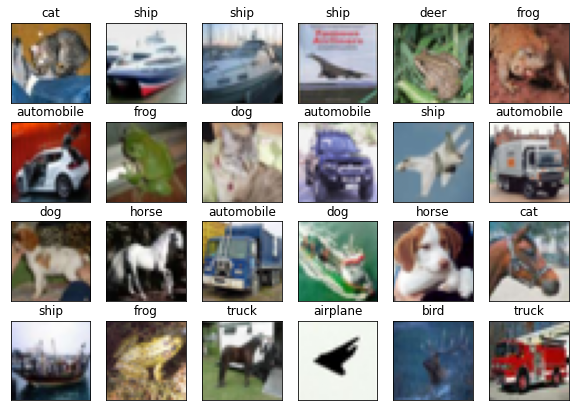

In [22]:
show_images_with_predicted_labels(X_test, np.argmax(ann_predictions, axis = 1))

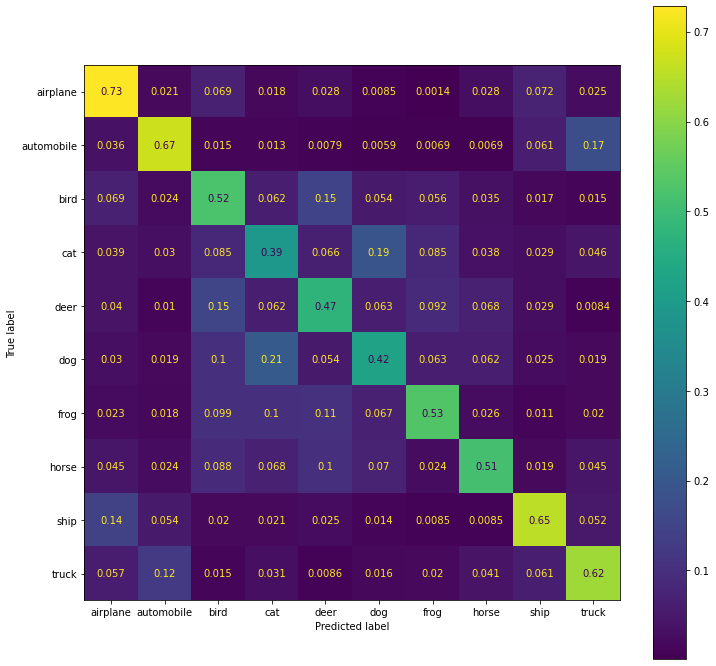

In [24]:
show_confusion_matrix(np.argmax(ann_predictions, axis = 1), Y_test, class_labels)

Ako je možné vidieť z matice zámen, trénovanie zvlášť modelu na základe nájdených parametrov z Grid Searchu nám naozaj vráti model s väčšou presnosťou, avšak presnosť klasifikácie je v rozmedzí `<0.39,0.73>`. Zobrazíme si ešte vývoj hodnoty stratovej funkcie a presnosti tohto modelu.

In [25]:
def loss_plot(history):
    plt.figure()
    plt.grid(True)
    plt.plot(history.history["loss"], label = "Trénovacie dáta")
    plt.plot(history.history["val_loss"], '--', label = "Validačné dáta")
    plt.title("Hodnota stratovej funkcie")
    plt.legend()

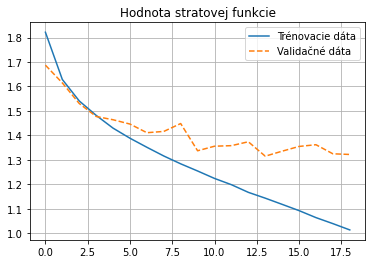

In [26]:
loss_plot(ann_history)

In [27]:
def accuracy_plot(history):
    plt.figure()
    plt.grid(True)
    plt.plot(history.history["sparse_categorical_accuracy"], label = "Trénovacie dáta")
    plt.plot(history.history["val_sparse_categorical_accuracy"], '--', label = "Validačné dáta")
    plt.title("Presnosť")
    plt.legend()

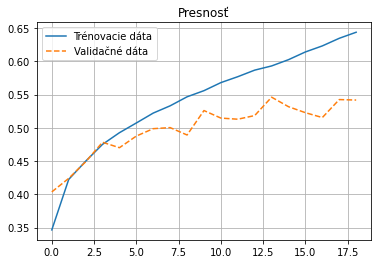

In [58]:
accuracy_plot(ann_history)

In [59]:
loss, accuracy = ann_model.evaluate(X_test, Y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.3148 - sparse_categorical_accuracy: 0.5460


In [60]:
print(f'Presnosť modelu je {accuracy * 100}%, hodnota loss funkcie: {loss}')

Presnosť modelu je 54.60000038146973%, hodnota loss funkcie: 1.3148216009140015


Presnosť horeuvedeného modelu sa ani zďaleka neblíži k 80%, nakoľko pre klasifikáciu obrázkov nie je takáto architektúra siete vhodná. Vhodnejšou architektúrou siete pre tento účel sú tzv. konvolučné siete (CNN), ktoré fungujú na odlišnom princípe.
V ďaľších krokoch sa budem pokúšať nájsť vhodnú architektúru siete spolu s hyperparametrami vhodnými pre klasifikáciu obrázkov z CIFAR-10 datasetu.

## CNN

V tejto časti sa budem venovať vytvoreniu optimálneho modelu CNN siete pre klasifikáciu rovnakého datasetu.

Najprv si vytvoríme wrapper funkcie, ktoré budú potrebné pre nájdenie optimálneho modelu pre klasifikáciu obrázkov z datasetu. Tieto funkcie budú nasledné používané grid searchom pre hľadanie optimálnych hyperparametrov.
Najprv som vyskúšal nasledovný model, ktorý pozostáva z jednej 2D konvolučnej vrstvy na vstupe a následne konštruoval 2D konvolučnú vrstvu spolu s Max Poolingom v loope podľa počtu zadaných skrytých konvolučných vrstiev (do úvahy sa tým pádom nepočítala vstupná konvolučná vrstva).
Ako regularizáciu som využil dropout, ktorého optimálnu hodnotu som následne hľadal pomocou Grid Searchu pre model s 3/4/5 konvolučnými vrstvami.

In [61]:
def base_cnn_model(no_of_conv_layers = 3, starting_filter_dim = 16, kernel_size = 3, metrics = 'accuracy', dropout = 0):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(starting_filter_dim, kernel_size, activation = tf.nn.relu, input_shape = (32, 32, 3), padding = "same"))
    
    filter_dim = starting_filter_dim
    for layer in range(no_of_conv_layers):
        model.add(tf.keras.layers.Conv2D(filter_dim, kernel_size, activation = tf.nn.relu, padding="same"))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        if dropout != 0:
            model.add(tf.keras.layers.Dropout(dropout))
        filter_dim *= 2
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(filter_dim * 2, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))
    
    # compile model
    model.compile(
        optimizer = tf.optimizers.SGD(),
        loss = tf.losses.SparseCategoricalCrossentropy(),
        metrics=[metrics]
        # [tf.metrics.SparseCategoricalAccuracy()]
    )
    
    return model

def base_cnn_model_3(starting_filter_dim = 16, kernel_size = 3, metrics = 'accuracy', dropout = 0):
    return base_cnn_model(no_of_conv_layers = 3, starting_filter_dim = starting_filter_dim, kernel_size = kernel_size, metrics = metrics, dropout = dropout)

def base_cnn_model_4(starting_filter_dim = 16, kernel_size = 3, metrics = 'accuracy', dropout = 0):
    return base_cnn_model(no_of_conv_layers = 4, starting_filter_dim = starting_filter_dim, kernel_size = kernel_size, metrics = metrics, dropout = dropout)

def base_cnn_model_5(starting_filter_dim = 16, kernel_size = 3, metrics = 'accuracy', dropout = 0):
    return base_cnn_model(no_of_conv_layers = 5, starting_filter_dim = starting_filter_dim, kernel_size = kernel_size, metrics = metrics, dropout = dropout)

In [62]:
cnn_3_gs = grid_search(base_cnn_model_3, grid_search_params=dict(dropout=[0.3, 0.5, 0.7]))

/var/folders/x8/bld_jpn12sgcxmqz5t3y6wb80000gn/T/ipykernel_87136/3117033963.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model_wrapper = KerasClassifier(build_fn = model, verbose = 1)
2022-06-21 20:48:37.611263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 2.0906 - accuracy: 0.2233

2022-06-21 20:48:47.744005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20/313 [>.............................] - ETA: 1s - loss: 1.9229 - accuracy: 0.2891

2022-06-21 20:48:49.352668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 1.9609 - accuracy: 0.2888


2022-06-21 20:48:53.316440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1243/1250 [============================>.] - ETA: 0s - loss: 2.0865 - accuracy: 0.2276

2022-06-21 20:49:03.339140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 19/313 [>.............................] - ETA: 1s - loss: 2.0040 - accuracy: 0.3092

2022-06-21 20:49:05.083504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1250 [..............................] - ETA: 13:58 - loss: 2.3422 - accuracy: 0.0625

2022-06-21 20:49:09.906635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 2.1008 - accuracy: 0.2163

2022-06-21 20:49:19.533122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 19/313 [>.............................] - ETA: 1s - loss: 1.9722 - accuracy: 0.2928

2022-06-21 20:49:20.961344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1250 [..............................] - ETA: 5:54 - loss: 2.3332 - accuracy: 0.0938

2022-06-21 20:49:24.205144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1247/1250 [============================>.] - ETA: 0s - loss: 2.0923 - accuracy: 0.2217

2022-06-21 20:49:34.797504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  9/313 [..............................] - ETA: 2s - loss: 1.9654 - accuracy: 0.2917 

2022-06-21 20:49:36.405244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 1.9500 - accuracy: 0.3103


2022-06-21 20:49:39.696833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 2.0867 - accuracy: 0.2263

2022-06-21 20:49:49.783962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 16/313 [>.............................] - ETA: 2s - loss: 1.9880 - accuracy: 0.2910

2022-06-21 20:49:51.696273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 1.9646 - accuracy: 0.2877


2022-06-21 20:49:55.714243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 2.1343 - accuracy: 0.2033

2022-06-21 20:50:06.236071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 17/313 [>.............................] - ETA: 1s - loss: 2.0100 - accuracy: 0.2757

2022-06-21 20:50:07.797369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.0349 - accuracy: 0.2589


2022-06-21 20:50:11.745567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.1321 - accuracy: 0.2092

2022-06-21 20:50:21.844804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 18/313 [>.............................] - ETA: 1s - loss: 2.1708 - accuracy: 0.1979

2022-06-21 20:50:23.493402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.1439 - accuracy: 0.1970


2022-06-21 20:50:27.887975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 2.1438 - accuracy: 0.1998

2022-06-21 20:50:38.078356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20/313 [>.............................] - ETA: 1s - loss: 2.0427 - accuracy: 0.2547

2022-06-21 20:50:39.815095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.0504 - accuracy: 0.2634


2022-06-21 20:50:43.597841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 2.1383 - accuracy: 0.2084

2022-06-21 20:50:53.628519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20/313 [>.............................] - ETA: 1s - loss: 2.0989 - accuracy: 0.2078

2022-06-21 20:50:55.454487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.0922 - accuracy: 0.2356


2022-06-21 20:50:59.537452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 2.1521 - accuracy: 0.2010

2022-06-21 20:51:09.076290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20/313 [>.............................] - ETA: 1s - loss: 2.0760 - accuracy: 0.2547

2022-06-21 20:51:10.560570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1250 [..............................] - ETA: 47:13 - loss: 2.5819 - accuracy: 0.1562

2022-06-21 20:51:15.650218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 2.1665 - accuracy: 0.2034

2022-06-21 20:51:24.275449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 21/313 [=>............................] - ETA: 1s - loss: 2.3184 - accuracy: 0.1176

2022-06-21 20:51:25.715484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1250 [..............................] - ETA: 5:54 - loss: 2.5871 - accuracy: 0.0938

2022-06-21 20:51:28.055813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 2.1755 - accuracy: 0.1902

2022-06-21 20:51:37.360591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 17/313 [>.............................] - ETA: 1s - loss: 2.2825 - accuracy: 0.1250

2022-06-21 20:51:38.944605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.2650 - accuracy: 0.1236


2022-06-21 20:51:41.883984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.1774 - accuracy: 0.1950

2022-06-21 20:51:51.554666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 21/313 [=>............................] - ETA: 1s - loss: 2.3223 - accuracy: 0.1012

2022-06-21 20:51:53.103698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.3269 - accuracy: 0.1011


2022-06-21 20:51:55.638989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.1613 - accuracy: 0.2011

2022-06-21 20:52:06.542883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  9/313 [..............................] - ETA: 1s - loss: 2.3224 - accuracy: 0.0938 

2022-06-21 20:52:08.148570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.3191 - accuracy: 0.1097


2022-06-21 20:52:12.019565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 2.1567 - accuracy: 0.2023

2022-06-21 20:52:21.978937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 16/313 [>.............................] - ETA: 2s - loss: 2.3313 - accuracy: 0.0996

2022-06-21 20:52:23.858963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.3132 - accuracy: 0.1110


In [63]:
cnn_4_gs = grid_search(base_cnn_model_4, grid_search_params=dict(dropout=[0.3, 0.5, 0.7]))

/var/folders/x8/bld_jpn12sgcxmqz5t3y6wb80000gn/T/ipykernel_87136/3117033963.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model_wrapper = KerasClassifier(build_fn = model, verbose = 1)
2022-06-21 20:55:48.811860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.1590 - accuracy: 0.1847

2022-06-21 20:55:59.717163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  8/313 [..............................] - ETA: 2s - loss: 2.0855 - accuracy: 0.1875 

2022-06-21 20:56:01.471621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.0579 - accuracy: 0.2289


2022-06-21 20:56:05.715147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 2.1379 - accuracy: 0.1958

2022-06-21 20:56:16.057617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  9/313 [..............................] - ETA: 2s - loss: 2.0489 - accuracy: 0.2847 

2022-06-21 20:56:17.853796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.0236 - accuracy: 0.2702


2022-06-21 20:56:21.862687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 2.1432 - accuracy: 0.1949

2022-06-21 20:56:33.437004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  8/313 [..............................] - ETA: 2s - loss: 2.0165 - accuracy: 0.2305 

2022-06-21 20:56:35.491278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.0097 - accuracy: 0.2680


2022-06-21 20:56:39.744531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 2.1517 - accuracy: 0.1910

2022-06-21 20:56:53.839919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  7/313 [..............................] - ETA: 2s - loss: 2.0216 - accuracy: 0.2455 

2022-06-21 20:56:55.417877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.0283 - accuracy: 0.2590


2022-06-21 20:56:58.171573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.1445 - accuracy: 0.1945

2022-06-21 20:57:08.856251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  8/313 [..............................] - ETA: 2s - loss: 2.0325 - accuracy: 0.2500 

2022-06-21 20:57:10.409556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.0212 - accuracy: 0.2705


2022-06-21 20:57:13.407941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 2.2150 - accuracy: 0.1568

2022-06-21 20:57:25.080059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  8/313 [..............................] - ETA: 2s - loss: 2.1107 - accuracy: 0.2383 

2022-06-21 20:57:26.724247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.0999 - accuracy: 0.2188


2022-06-21 20:57:30.844052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1244/1250 [============================>.] - ETA: 0s - loss: 2.1924 - accuracy: 0.1694

2022-06-21 20:57:41.636143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  8/313 [..............................] - ETA: 2s - loss: 2.2184 - accuracy: 0.1758 

2022-06-21 20:57:43.320873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.2122 - accuracy: 0.1616


2022-06-21 20:57:47.083905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 2.2562 - accuracy: 0.1463

2022-06-21 20:57:58.136124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 1:05 - loss: 2.3497 - accuracy: 0.1250

2022-06-21 20:57:59.848891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.2914 - accuracy: 0.1076


2022-06-21 20:58:04.042844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 2.2388 - accuracy: 0.1573

2022-06-21 20:58:14.914288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  6/313 [..............................] - ETA: 3s - loss: 2.2461 - accuracy: 0.1198 

2022-06-21 20:58:16.597757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.2602 - accuracy: 0.1282


2022-06-21 20:58:20.923956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 2.1934 - accuracy: 0.1688

2022-06-21 20:58:31.689347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  7/313 [..............................] - ETA: 2s - loss: 2.1152 - accuracy: 0.2455 

2022-06-21 20:58:33.277963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.1086 - accuracy: 0.2332


2022-06-21 20:58:37.359184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1244/1250 [============================>.] - ETA: 0s - loss: 2.2087 - accuracy: 0.1698

2022-06-21 20:58:47.611803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  9/313 [..............................] - ETA: 2s - loss: 2.3465 - accuracy: 0.1181 

2022-06-21 20:58:49.216033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.3533 - accuracy: 0.1029


2022-06-21 20:58:53.250474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.2487 - accuracy: 0.1480

2022-06-21 20:59:03.782583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  7/313 [..............................] - ETA: 2s - loss: 2.3506 - accuracy: 0.0982 

2022-06-21 20:59:05.403389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.3312 - accuracy: 0.0984


2022-06-21 20:59:10.316175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1244/1250 [============================>.] - ETA: 0s - loss: 2.2635 - accuracy: 0.1341

2022-06-21 20:59:20.091070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  7/313 [..............................] - ETA: 2s - loss: 2.2913 - accuracy: 0.1027 

2022-06-21 20:59:21.605431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.3116 - accuracy: 0.1005


2022-06-21 20:59:24.049151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1247/1250 [============================>.] - ETA: 0s - loss: 2.2381 - accuracy: 0.1552

2022-06-21 20:59:34.319211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  8/313 [..............................] - ETA: 2s - loss: 2.3441 - accuracy: 0.0898 

2022-06-21 20:59:35.883919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.3384 - accuracy: 0.1003


2022-06-21 20:59:38.317926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 2.2414 - accuracy: 0.1519

2022-06-21 20:59:47.994417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  7/313 [..............................] - ETA: 2s - loss: 2.3291 - accuracy: 0.0982 

2022-06-21 20:59:49.782992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.3322 - accuracy: 0.0999


In [65]:
cnn_5_gs = grid_search(base_cnn_model_5, grid_search_params=dict(dropout=[0.3, 0.5, 0.7]))

/var/folders/x8/bld_jpn12sgcxmqz5t3y6wb80000gn/T/ipykernel_87136/3117033963.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model_wrapper = KerasClassifier(build_fn = model, verbose = 1)
2022-06-21 21:04:07.098042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.2188 - accuracy: 0.1580

2022-06-21 21:04:18.672545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 58s - loss: 2.1331 - accuracy: 0.2188

2022-06-21 21:04:20.564664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.1644 - accuracy: 0.2294


2022-06-21 21:04:24.803835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1244/1250 [============================>.] - ETA: 0s - loss: 2.2185 - accuracy: 0.1591

2022-06-21 21:04:36.237619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 59s - loss: 2.0924 - accuracy: 0.3750

2022-06-21 21:04:38.093860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.1522 - accuracy: 0.2103


2022-06-21 21:04:42.672871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.2165 - accuracy: 0.1603

2022-06-21 21:04:54.279218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 1:20 - loss: 2.2210 - accuracy: 0.2500

2022-06-21 21:04:56.549497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.1906 - accuracy: 0.1842


2022-06-21 21:05:04.008071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.2171 - accuracy: 0.1618

2022-06-21 21:05:15.265704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  6/313 [..............................] - ETA: 3s - loss: 2.1543 - accuracy: 0.2240 

2022-06-21 21:05:16.926686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.1560 - accuracy: 0.2366


2022-06-21 21:05:19.831259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 2.2151 - accuracy: 0.1613

2022-06-21 21:05:31.442787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  6/313 [..............................] - ETA: 3s - loss: 2.1349 - accuracy: 0.2500 

2022-06-21 21:05:33.144431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.1382 - accuracy: 0.2400


2022-06-21 21:05:35.884553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 2.2060 - accuracy: 0.1697

2022-06-21 21:05:48.215710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 1:08 - loss: 2.2123 - accuracy: 0.1875

2022-06-21 21:05:50.001027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.2752 - accuracy: 0.1163


2022-06-21 21:05:53.556025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.2027 - accuracy: 0.1712

2022-06-21 21:06:05.473008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 1:04 - loss: 2.2298 - accuracy: 0.2812

2022-06-21 21:06:07.443471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.2905 - accuracy: 0.1108


2022-06-21 21:06:11.594696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 2.2030 - accuracy: 0.1703

2022-06-21 21:06:23.252498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  7/313 [..............................] - ETA: 3s - loss: 2.2587 - accuracy: 0.1161 

2022-06-21 21:06:25.124564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.2747 - accuracy: 0.1160


2022-06-21 21:06:29.399232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 2.2010 - accuracy: 0.1703

2022-06-21 21:06:43.665457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 57s - loss: 2.2628 - accuracy: 0.1250

2022-06-21 21:06:45.729785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.3074 - accuracy: 0.1060


2022-06-21 21:06:49.618827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.2016 - accuracy: 0.1695

2022-06-21 21:07:04.563176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 59s - loss: 2.2866 - accuracy: 0.0625

2022-06-21 21:07:06.400530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.2868 - accuracy: 0.1122


2022-06-21 21:07:13.233052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.1858 - accuracy: 0.1835

2022-06-21 21:07:24.681281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  5/313 [..............................] - ETA: 3s - loss: 2.3434 - accuracy: 0.1000 

2022-06-21 21:07:26.760973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.3692 - accuracy: 0.1030


2022-06-21 21:07:30.094264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 2.1915 - accuracy: 0.1790

2022-06-21 21:07:42.210369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 1:07 - loss: 2.2755 - accuracy: 0.3125

2022-06-21 21:07:44.338786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.3624 - accuracy: 0.1008


2022-06-21 21:07:47.911806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 2.1886 - accuracy: 0.1843

2022-06-21 21:07:59.897253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 1:00 - loss: 2.3128 - accuracy: 0.2188

2022-06-21 21:08:01.934756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.3673 - accuracy: 0.0978


2022-06-21 21:08:06.241954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1247/1250 [============================>.] - ETA: 0s - loss: 2.1863 - accuracy: 0.1871

2022-06-21 21:08:18.277959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 14s 10ms/step - loss: 2.1862 - accuracy: 0.1873 - val_loss: 2.3710 - val_accuracy: 0.1000


2022-06-21 21:08:20.378607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.3703 - accuracy: 0.1004


2022-06-21 21:08:24.627702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.1897 - accuracy: 0.1815

2022-06-21 21:08:36.499309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  7/313 [..............................] - ETA: 3s - loss: 2.3762 - accuracy: 0.0804 

2022-06-21 21:08:38.328878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.3706 - accuracy: 0.0980


Vidíme, že optimálny dropout rate pre každý model mal hodnotu 0.3:

In [66]:
cnn_3_gs.best_params_

{'dropout': 0.3}

In [67]:
cnn_4_gs.best_params_

{'dropout': 0.3}

In [68]:
cnn_5_gs.best_params_

{'dropout': 0.3}

Následne som trénoval 3 modely s optimálnym dropoutom:

In [69]:
cnn_3 = base_cnn_model_3(dropout=0.3, metrics=tf.metrics.SparseCategoricalAccuracy())
cnn_3_history = cnn_3.fit(X_train, Y_train, epochs = 200, batch_size = 16, verbose = 1, callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)], validation_data = (X_test, Y_test))

Epoch 1/200


2022-06-21 21:36:50.363598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - ETA: 0s - loss: 1.9655 - sparse_categorical_accuracy: 0.2805

2022-06-21 21:37:12.895201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - 25s 8ms/step - loss: 1.9655 - sparse_categorical_accuracy: 0.2805 - val_loss: 1.8638 - val_sparse_categorical_accuracy: 0.3362
Epoch 2/200
3125/3125 [==============================] - 23s 7ms/step - loss: 1.6060 - sparse_categorical_accuracy: 0.4197 - val_loss: 1.4789 - val_sparse_categorical_accuracy: 0.4759
Epoch 3/200
3125/3125 [==============================] - 23s 7ms/step - loss: 1.4089 - sparse_categorical_accuracy: 0.4912 - val_loss: 1.3261 - val_sparse_categorical_accuracy: 0.5239
Epoch 4/200
3125/3125 [==============================] - 23s 7ms/step - loss: 1.2882 - sparse_categorical_accuracy: 0.5375 - val_loss: 1.1876 - val_sparse_categorical_accuracy: 0.5794
Epoch 5/200
3125/3125 [==============================] - 23s 7ms/step - loss: 1.1965 - sparse_categorical_accuracy: 0.5719 - val_loss: 1.1125 - val_sparse_categorical_accuracy: 0.6083
Epoch 6/200
3125/3125 [==============================] - 23s 7ms/step - loss: 1.1173 - spars

In [70]:
cnn_4 = base_cnn_model_4(dropout=0.3, metrics=tf.metrics.SparseCategoricalAccuracy())
cnn_4_history = cnn_4.fit(X_train, Y_train, epochs = 200, batch_size = 16, verbose = 1, callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)], validation_data = (X_test, Y_test))

Epoch 1/200


2022-06-21 21:49:34.510580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3123/3125 [============================>.] - ETA: 0s - loss: 2.0090 - sparse_categorical_accuracy: 0.2552

2022-06-21 21:49:59.429672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - 27s 9ms/step - loss: 2.0090 - sparse_categorical_accuracy: 0.2552 - val_loss: 1.8359 - val_sparse_categorical_accuracy: 0.3564
Epoch 2/200
3125/3125 [==============================] - 25s 8ms/step - loss: 1.6699 - sparse_categorical_accuracy: 0.3888 - val_loss: 1.5682 - val_sparse_categorical_accuracy: 0.4508
Epoch 3/200
3125/3125 [==============================] - 25s 8ms/step - loss: 1.4771 - sparse_categorical_accuracy: 0.4618 - val_loss: 1.4565 - val_sparse_categorical_accuracy: 0.4715
Epoch 4/200
3125/3125 [==============================] - 25s 8ms/step - loss: 1.3635 - sparse_categorical_accuracy: 0.5063 - val_loss: 1.3838 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/200
3125/3125 [==============================] - 26s 8ms/step - loss: 1.2831 - sparse_categorical_accuracy: 0.5374 - val_loss: 1.2966 - val_sparse_categorical_accuracy: 0.5252
Epoch 6/200
3125/3125 [==============================] - 26s 8ms/step - loss: 1.2114 - spars

In [71]:
cnn_5 = base_cnn_model_5(dropout=0.3, metrics=tf.metrics.SparseCategoricalAccuracy())
cnn_5_history = cnn_5.fit(X_train, Y_train, epochs = 200, batch_size = 16, verbose = 1, callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)], validation_data = (X_test, Y_test))

Epoch 1/200


2022-06-21 22:18:28.466620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3120/3125 [============================>.] - ETA: 0s - loss: 2.1073 - sparse_categorical_accuracy: 0.2156

2022-06-21 22:18:55.338495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - 30s 9ms/step - loss: 2.1071 - sparse_categorical_accuracy: 0.2158 - val_loss: 2.0896 - val_sparse_categorical_accuracy: 0.2380
Epoch 2/200
3125/3125 [==============================] - 29s 9ms/step - loss: 1.8368 - sparse_categorical_accuracy: 0.3156 - val_loss: 1.8410 - val_sparse_categorical_accuracy: 0.3286
Epoch 3/200
3125/3125 [==============================] - 28s 9ms/step - loss: 1.6221 - sparse_categorical_accuracy: 0.3959 - val_loss: 1.6198 - val_sparse_categorical_accuracy: 0.4212
Epoch 4/200
3125/3125 [==============================] - 28s 9ms/step - loss: 1.4831 - sparse_categorical_accuracy: 0.4527 - val_loss: 1.5425 - val_sparse_categorical_accuracy: 0.4538
Epoch 5/200
3125/3125 [==============================] - 27s 9ms/step - loss: 1.3784 - sparse_categorical_accuracy: 0.4960 - val_loss: 1.5777 - val_sparse_categorical_accuracy: 0.4168
Epoch 6/200
3125/3125 [==============================] - 27s 9ms/step - loss: 1.2963 - spars

Po trénovaní daných modelov si zobrazíme matice zámen a vývoj priebehu presnosti a hodnoty loss funkcie pre každý trénovaný model

Štatistiky pre model s 3 skrytými konvolučnými vrstvami:

2022-06-21 22:33:15.802437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


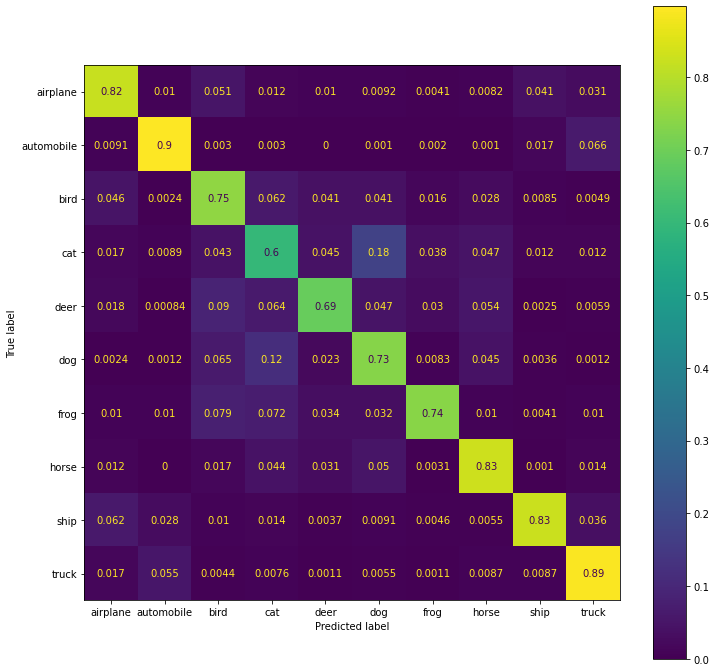

In [72]:
show_confusion_matrix(np.argmax(cnn_3.predict(X_test), axis = 1), Y_test, class_labels)

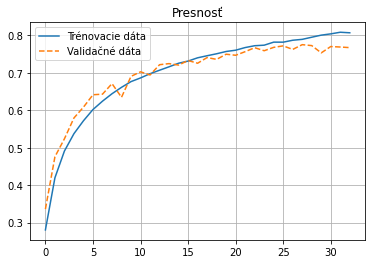

In [73]:
accuracy_plot(cnn_3_history)

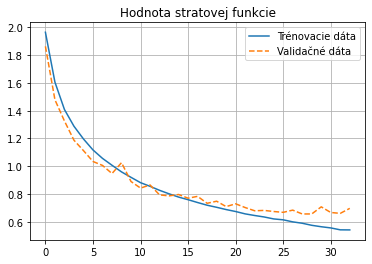

In [74]:
loss_plot(cnn_3_history)

In [75]:
cnn_3_loss, cnn_3_accuracy = cnn_3.evaluate(X_test, Y_test)

  5/313 [..............................] - ETA: 4s - loss: 0.5641 - sparse_categorical_accuracy: 0.8375 

2022-06-21 22:33:17.637850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 0.6560 - sparse_categorical_accuracy: 0.7751


In [76]:
cnn_3_accuracy

0.77510005235672

Štatistiky pre model so 4 skrytými konvolučnými vrstvami:

2022-06-21 22:33:19.851076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


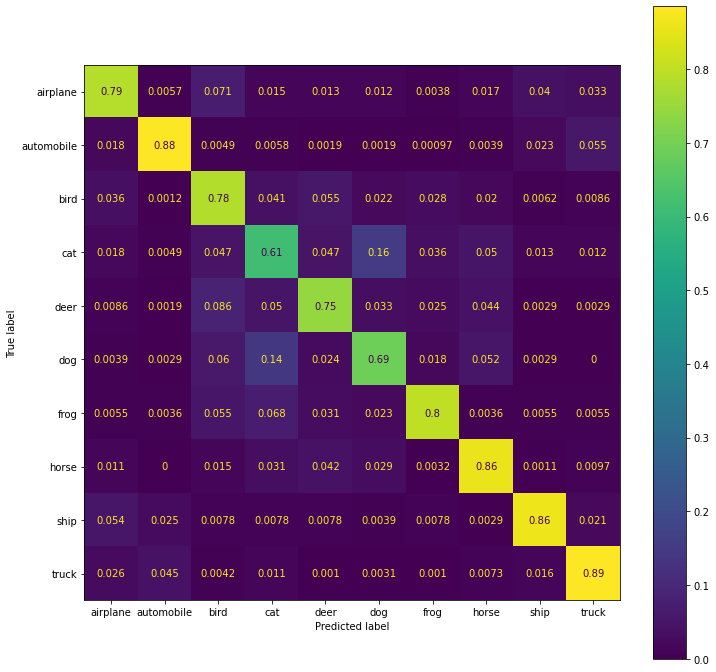

In [77]:
show_confusion_matrix(np.argmax(cnn_4.predict(X_test), axis = 1), Y_test, class_labels)

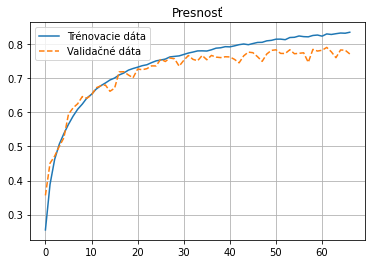

In [78]:
accuracy_plot(cnn_4_history)

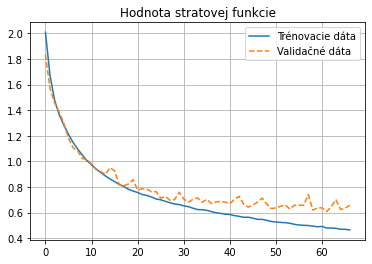

In [79]:
loss_plot(cnn_4_history)

In [80]:
cnn_4_loss, cnn_4_accuracy = cnn_4.evaluate(X_test, Y_test)

  1/313 [..............................] - ETA: 1:13 - loss: 0.4676 - sparse_categorical_accuracy: 0.8750

2022-06-21 22:33:21.215978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 0.6073 - sparse_categorical_accuracy: 0.7902


In [81]:
cnn_4_accuracy

0.7902000546455383

Štatistiky pre model s 5 skrytými konvolučnými vrstvami:

2022-06-21 22:33:23.355392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


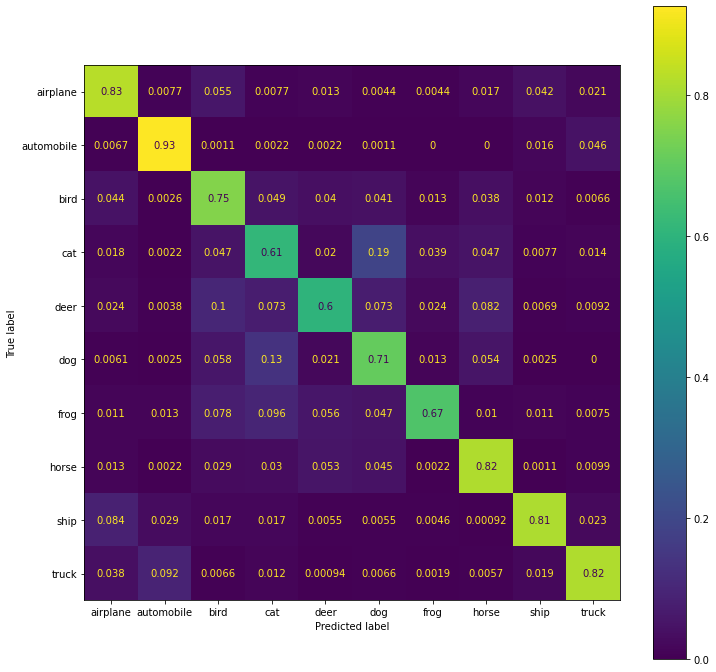

In [82]:
show_confusion_matrix(np.argmax(cnn_5.predict(X_test), axis = 1), Y_test, class_labels)

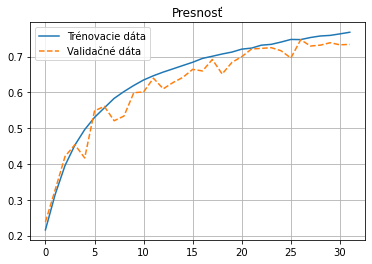

In [83]:
accuracy_plot(cnn_5_history)

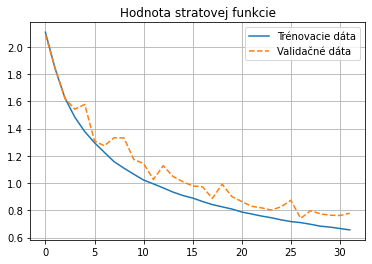

In [84]:
loss_plot(cnn_5_history)

In [85]:
cnn_5_loss, cnn_5_accuracy = cnn_5.evaluate(X_test, Y_test)

2022-06-21 22:33:24.829382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 0.7407 - sparse_categorical_accuracy: 0.7472


In [86]:
cnn_5_accuracy

0.7472000122070312

In [88]:
cnn_5.summary()

Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_324 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_325 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_262 (MaxPooli  (None, 16, 16, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_262 (Dropout)       (None, 16, 16, 16)        0         
                                                                 
 conv2d_326 (Conv2D)         (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_263 (MaxPooli  (None, 8, 8, 32)         0         
 ng2D)                                              

### Experimentálna časť

V tejto sekcii sa budem snažiť vylepšiť presnosť predikcie modelu s 5 skrytými konvolučnými vrstvami, ktorý som si zvolil na základe grafov a výsledných hodnôt presnosti modelov s 3/4/5 skrytými konvolučnými vrstvami. I keď presnosť dosahuje cca o 4,5% menej, avšak krivka hodnoty loss funkcie a accuracy validačných dát kopíruje krivky na testovacích dátach najlepšie.

Do daného modelu pridáme `Batch Normalization` vrstvu, ktorá by mohla pomôcť zlepšiť presnosť. Dropout necháme na hodnote `0.3` a počet neurónov v skrytej dense vrstve som na základe experimentálnych overení nastavil na 256.

In [91]:
def base_cnn_model_5_with_normalization(metrics = 'accuracy', starting_filter_dim = 16, kernel_size = 3):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(starting_filter_dim, kernel_size, activation = tf.nn.relu, input_shape = (32, 32, 3), padding = "same"))
    
    filter_dim = starting_filter_dim
    for layer in range(5):
        model.add(tf.keras.layers.Conv2D(filter_dim, kernel_size, activation = tf.nn.relu, padding="same"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Dropout(0.3))
        filter_dim *= 2
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))
    
    # compile model
    model.compile(
        optimizer = tf.optimizers.SGD(),
        loss = tf.losses.SparseCategoricalCrossentropy(),
        metrics=[metrics]
        # [tf.metrics.SparseCategoricalAccuracy()]
    )
    
    return model

Pokúsime sa nájsť vhodný počet filtrov pre skryté konvolučné vrstvy. Počet filtrov v skrytej konvolučnej vrstve je dvojnásobkom počtu filtrov v predchádzajúcej skrytej konvolučnej vrstve. Tento postup určovania počtu filtrov je pri navrhovaní CNN sietí bežný - takýmto spôsobom majú skryté konvolučné vrstvy bližšie k výstupnej vrstve možnosť naučiť sa väčšiu kombináciu vzorov zo vstupu.

In [92]:
cnn_5_norm_gs = grid_search(base_cnn_model_5_with_normalization, grid_search_params=dict(starting_filter_dim=[16, 32], kernel_size=[3, 5]))

/var/folders/x8/bld_jpn12sgcxmqz5t3y6wb80000gn/T/ipykernel_87136/3117033963.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model_wrapper = KerasClassifier(build_fn = model, verbose = 1)
2022-06-21 22:43:52.892182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 1.9002 - accuracy: 0.3105

2022-06-21 22:44:09.538505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 20s 14ms/step - loss: 1.8996 - accuracy: 0.3106 - val_loss: 2.0516 - val_accuracy: 0.3086


2022-06-21 22:44:12.734362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 2.0311 - accuracy: 0.3086


2022-06-21 22:44:18.318766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 1.8776 - accuracy: 0.3219

2022-06-21 22:44:34.289142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 18s 13ms/step - loss: 1.8773 - accuracy: 0.3219 - val_loss: 2.1071 - val_accuracy: 0.2853


2022-06-21 22:44:37.544207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step - loss: 2.1318 - accuracy: 0.2790


2022-06-21 22:44:41.034663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 1.9103 - accuracy: 0.3050

2022-06-21 22:44:57.113171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 1:00 - loss: 2.1402 - accuracy: 0.3438

2022-06-21 22:44:59.271207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step - loss: 2.0444 - accuracy: 0.3050


2022-06-21 22:45:03.244937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 1.9200 - accuracy: 0.3030

2022-06-21 22:45:18.446385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 1:07 - loss: 1.7852 - accuracy: 0.3125

2022-06-21 22:45:20.758354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.0365 - accuracy: 0.2942


2022-06-21 22:45:25.405666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 1.9061 - accuracy: 0.3148

2022-06-21 22:45:42.630662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 20s 15ms/step - loss: 1.9055 - accuracy: 0.3149 - val_loss: 1.9057 - val_accuracy: 0.3172


2022-06-21 22:45:45.331207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 7ms/step - loss: 1.9198 - accuracy: 0.3159


2022-06-21 22:45:50.454820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 1.8385 - accuracy: 0.3370

2022-06-21 22:46:09.431084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 21s 16ms/step - loss: 1.8385 - accuracy: 0.3370 - val_loss: 1.7834 - val_accuracy: 0.3853


2022-06-21 22:46:12.152828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 1.7914 - accuracy: 0.3796


2022-06-21 22:46:17.464063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 1.8305 - accuracy: 0.3387

2022-06-21 22:46:36.212738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 21s 16ms/step - loss: 1.8303 - accuracy: 0.3388 - val_loss: 2.0711 - val_accuracy: 0.3590


2022-06-21 22:46:38.505416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 2.1157 - accuracy: 0.3521


2022-06-21 22:46:46.282847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 1.8626 - accuracy: 0.3299

2022-06-21 22:47:04.448572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 24s 16ms/step - loss: 1.8626 - accuracy: 0.3299 - val_loss: 1.7917 - val_accuracy: 0.3763


2022-06-21 22:47:06.868098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 1.7992 - accuracy: 0.3718


2022-06-21 22:47:10.659567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 1.8333 - accuracy: 0.3398

2022-06-21 22:47:29.721406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 22s 17ms/step - loss: 1.8331 - accuracy: 0.3398 - val_loss: 2.0279 - val_accuracy: 0.3473


2022-06-21 22:47:32.456644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 7ms/step - loss: 2.0475 - accuracy: 0.3460


2022-06-21 22:47:36.702524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 1.8467 - accuracy: 0.3347

2022-06-21 22:47:54.794398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 20s 16ms/step - loss: 1.8467 - accuracy: 0.3347 - val_loss: 1.6357 - val_accuracy: 0.4116


2022-06-21 22:47:57.352405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 7ms/step - loss: 1.6472 - accuracy: 0.4075


2022-06-21 22:48:02.235630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 1.8593 - accuracy: 0.3225

2022-06-21 22:48:20.988770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 21s 16ms/step - loss: 1.8590 - accuracy: 0.3224 - val_loss: 1.5532 - val_accuracy: 0.4290


2022-06-21 22:48:23.785426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 1.5470 - accuracy: 0.4307


2022-06-21 22:48:29.656751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 1.8246 - accuracy: 0.3377

2022-06-21 22:48:47.432348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 20s 15ms/step - loss: 1.8236 - accuracy: 0.3381 - val_loss: 1.5750 - val_accuracy: 0.4305


2022-06-21 22:48:50.369512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 1.6035 - accuracy: 0.4288


2022-06-21 22:48:55.666551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1247/1250 [============================>.] - ETA: 0s - loss: 1.8458 - accuracy: 0.3305

2022-06-21 22:49:13.136225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 20s 15ms/step - loss: 1.8455 - accuracy: 0.3306 - val_loss: 1.6968 - val_accuracy: 0.4040


2022-06-21 22:49:15.570579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 7ms/step - loss: 1.6837 - accuracy: 0.4063


2022-06-21 22:49:23.760118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 1.8545 - accuracy: 0.3274

2022-06-21 22:49:41.014938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 23s 15ms/step - loss: 1.8545 - accuracy: 0.3274 - val_loss: 2.0551 - val_accuracy: 0.2914


2022-06-21 22:49:43.647653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 2.0653 - accuracy: 0.2886


2022-06-21 22:49:47.688906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 1.8526 - accuracy: 0.3328

2022-06-21 22:50:04.799887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 20s 15ms/step - loss: 1.8524 - accuracy: 0.3329 - val_loss: 1.8974 - val_accuracy: 0.3414


2022-06-21 22:50:07.274011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 1.9272 - accuracy: 0.3279


2022-06-21 22:50:11.720700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 1.8140 - accuracy: 0.3452

2022-06-21 22:50:39.685989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 32s 24ms/step - loss: 1.8140 - accuracy: 0.3452 - val_loss: 1.9490 - val_accuracy: 0.3748


2022-06-21 22:50:43.464057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 4s 11ms/step - loss: 1.9359 - accuracy: 0.3744


2022-06-21 22:50:49.656234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 1.8122 - accuracy: 0.3451

2022-06-21 22:51:17.693271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 32s 24ms/step - loss: 1.8122 - accuracy: 0.3451 - val_loss: 1.5285 - val_accuracy: 0.4512


2022-06-21 22:51:21.600029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 4s 10ms/step - loss: 1.5571 - accuracy: 0.4453


2022-06-21 22:51:29.473033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 1.8116 - accuracy: 0.3464

2022-06-21 22:51:57.081650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 31s 24ms/step - loss: 1.8116 - accuracy: 0.3464 - val_loss: 2.2344 - val_accuracy: 0.2980


2022-06-21 22:52:00.771117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 4s 10ms/step - loss: 2.2532 - accuracy: 0.2886


2022-06-21 22:52:06.798849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 1.7788 - accuracy: 0.3537

2022-06-21 22:52:34.687813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 31s 24ms/step - loss: 1.7784 - accuracy: 0.3538 - val_loss: 1.9595 - val_accuracy: 0.3525


2022-06-21 22:52:38.276967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 4s 10ms/step - loss: 1.9864 - accuracy: 0.3434


2022-06-21 22:52:45.993471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 1.8129 - accuracy: 0.3441

2022-06-21 22:53:13.767116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 31s 24ms/step - loss: 1.8129 - accuracy: 0.3441 - val_loss: 1.6680 - val_accuracy: 0.4039


2022-06-21 22:53:17.197152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 4s 11ms/step - loss: 1.6872 - accuracy: 0.3944


In [93]:
cnn_5_norm_gs.best_params_

{'kernel_size': 5, 'starting_filter_dim': 16}

Vytvoríme si model s optimálnymi hyperparametrami z grid searchu.

In [94]:
cnn_model_5_norm = base_cnn_model_5_with_normalization(metrics=tf.metrics.SparseCategoricalAccuracy(), kernel_size=5, starting_filter_dim=16)

In [95]:
cnn_model_5_norm_history = cnn_model_5_norm.fit(X_train, Y_train, epochs = 200, batch_size = 16, verbose = 1, callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)], validation_data = (X_test, Y_test))

Epoch 1/200


2022-06-21 23:01:05.785013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3122/3125 [============================>.] - ETA: 0s - loss: 1.7752 - sparse_categorical_accuracy: 0.3474

2022-06-21 23:01:43.695577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - 42s 13ms/step - loss: 1.7749 - sparse_categorical_accuracy: 0.3474 - val_loss: 1.6657 - val_sparse_categorical_accuracy: 0.4073
Epoch 2/200
3125/3125 [==============================] - 40s 13ms/step - loss: 1.4151 - sparse_categorical_accuracy: 0.4834 - val_loss: 1.9332 - val_sparse_categorical_accuracy: 0.3949
Epoch 3/200
3125/3125 [==============================] - 40s 13ms/step - loss: 1.2555 - sparse_categorical_accuracy: 0.5470 - val_loss: 1.2837 - val_sparse_categorical_accuracy: 0.5530
Epoch 4/200
3125/3125 [==============================] - 39s 12ms/step - loss: 1.1435 - sparse_categorical_accuracy: 0.5912 - val_loss: 1.1133 - val_sparse_categorical_accuracy: 0.6068
Epoch 5/200
3125/3125 [==============================] - 39s 12ms/step - loss: 1.0698 - sparse_categorical_accuracy: 0.6198 - val_loss: 1.1428 - val_sparse_categorical_accuracy: 0.5985
Epoch 6/200
3125/3125 [==============================] - 39s 13ms/step - loss: 1.0073 -

Zobrazíme si maticu zámen a vyhodnotíme presnosť modelu.

2022-06-21 23:21:06.129413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


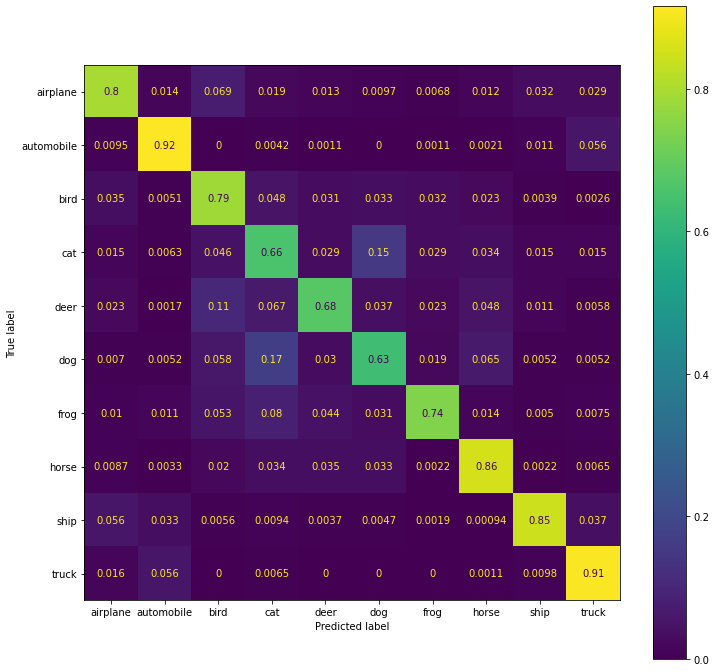

In [96]:
show_confusion_matrix(np.argmax(cnn_model_5_norm.predict(X_test), axis = 1), Y_test, class_labels)

In [97]:
cnn_5_norm_loss, cnn_5_norm_accuracy = cnn_model_5_norm.evaluate(X_test, Y_test)

2022-06-21 23:21:32.078021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 0.6379 - sparse_categorical_accuracy: 0.7782


In [98]:
cnn_5_norm_accuracy

0.7782000303268433

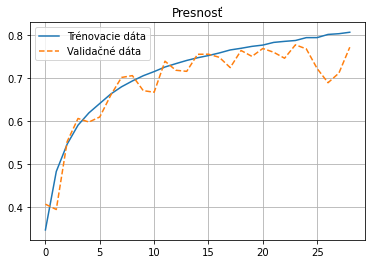

In [99]:
accuracy_plot(cnn_model_5_norm_history)

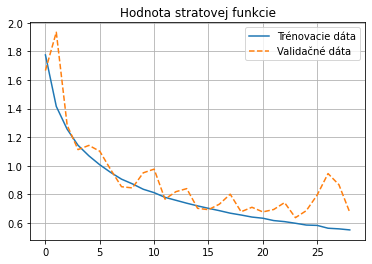

In [100]:
loss_plot(cnn_model_5_norm_history)

Presnosť nášho modelu vzrástla oproti predošlým modelom blízko k 78%, avšak z matice zámen vyplýva, že CNN má docela problém so správnou klasifikáciou obrázkov `dog` a `cat`, príp. `deer`. Pre mitigovanie tohto problému som vyskúšal pridať dve skryté konvolučné vrstvy pre každý loop namiesto jednej.

In [143]:
def base_cnn_model_5_with_normalization_2(metrics = 'accuracy', starting_filter_dim = 16, kernel_size = 3, optimizer = tf.optimizers.SGD()):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(starting_filter_dim, kernel_size, activation = tf.nn.relu, input_shape = (32, 32, 3), padding = "same"))
    
    filter_dim = starting_filter_dim
    for layer in range(5):
        model.add(tf.keras.layers.Conv2D(filter_dim, kernel_size, activation = tf.nn.relu, padding="same"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(filter_dim, kernel_size, activation = tf.nn.relu, padding="same"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Dropout(0.3))
        filter_dim *= 2
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))
    
    # compile model
    model.compile(
        optimizer = optimizer,
        loss = tf.losses.SparseCategoricalCrossentropy(),
        metrics=[metrics]
        # [tf.metrics.SparseCategoricalAccuracy()]
    )
    
    return model

In [102]:
cnn_5_norm_2 = base_cnn_model_5_with_normalization_2(metrics=tf.metrics.SparseCategoricalAccuracy(), kernel_size=5, starting_filter_dim=16)

In [103]:
cnn_5_norm_2_history = cnn_5_norm_2.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = 1, callbacks = [EarlyStopping(monitor = 'val_loss', patience = 8, restore_best_weights = True)], validation_data = (X_test, Y_test))

Epoch 1/200


2022-06-21 23:25:37.395896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.8369 - sparse_categorical_accuracy: 0.3332

2022-06-21 23:26:13.063842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 39s 24ms/step - loss: 1.8369 - sparse_categorical_accuracy: 0.3332 - val_loss: 1.6111 - val_sparse_categorical_accuracy: 0.4142
Epoch 2/200
1563/1563 [==============================] - 35s 23ms/step - loss: 1.4012 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.5413 - val_sparse_categorical_accuracy: 0.4610
Epoch 3/200
1563/1563 [==============================] - 35s 23ms/step - loss: 1.2040 - sparse_categorical_accuracy: 0.5657 - val_loss: 1.3655 - val_sparse_categorical_accuracy: 0.5077
Epoch 4/200
1563/1563 [==============================] - 36s 23ms/step - loss: 1.0756 - sparse_categorical_accuracy: 0.6169 - val_loss: 0.9515 - val_sparse_categorical_accuracy: 0.6600
Epoch 5/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.9712 - sparse_categorical_accuracy: 0.6580 - val_loss: 0.9093 - val_sparse_categorical_accuracy: 0.6774
Epoch 6/200
1563/1563 [==============================] - 35s 23ms/step - loss: 0.8978 -

Zobrazíme si štatistiky:

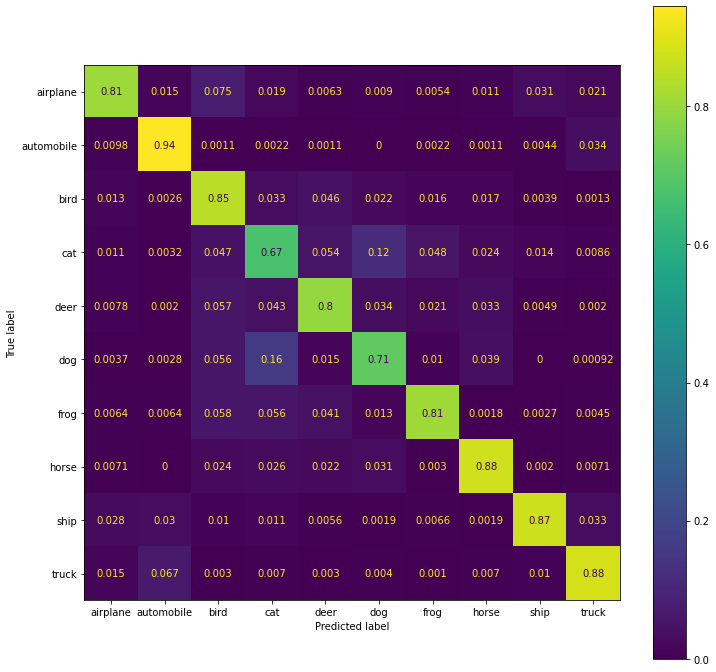

In [169]:
show_confusion_matrix(np.argmax(cnn_5_norm_2.predict(X_test), axis = 1), Y_test, class_labels)

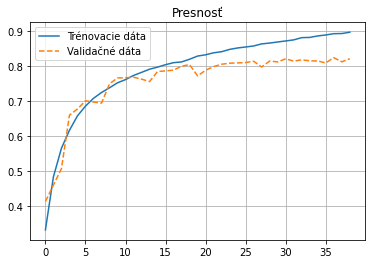

In [104]:
accuracy_plot(cnn_5_norm_2_history)

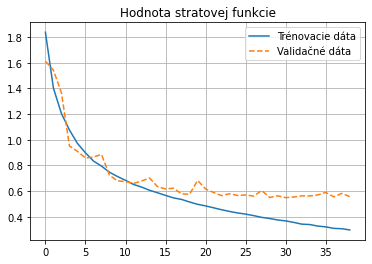

In [105]:
loss_plot(cnn_5_norm_2_history)

In [106]:
cnn_5_norm_2_loss, cnn_5_norm_2_accuracy = cnn_5_norm_2.evaluate(X_test, Y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.5489 - sparse_categorical_accuracy: 0.8204


In [107]:
cnn_5_norm_2_accuracy

0.820400059223175

Ako vidno zo štatistík, presnosť na validačných dátach sa nám síce zlepšila, ale model sa začal od cca 20 epochy preučovať. Jedna z ďalších metód regularizácií je včí. našom prípade image augmentation, ktorý som sa rozhodol využiť. Pomocou funkcie `ImageDataGenerator` som si definoval možné transformácie testovacích obrázkov, na základe ktorých sa naša CNN učí (`X_test`).

In [142]:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)

Taktiež som experimentálne zmenil optimizer na `Adam`, avšak po tejto zmene som si všimol, že `Adam` optimizer mi konvergoval v neskorších fázach učiaceho procesu pomalšie ako `SGD` -- preto som zmenil počet epôch na `200` a zvýšil `patience` pre `EarlyStopping` na `20`.

In [161]:
cnn_5_norm_2_augm = base_cnn_model_5_with_normalization_2(metrics=tf.metrics.SparseCategoricalAccuracy(), kernel_size=3, starting_filter_dim=16, optimizer = tf.optimizers.Adam())

In [ ]:
cnn_5_norm_2_augm_history = cnn_5_norm_2_augm.fit_generator(datagen.flow(X_train, Y_train, batch_size=128), epochs=200, verbose = 1, callbacks = [EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)], validation_data=(X_test, Y_test))

/var/folders/x8/bld_jpn12sgcxmqz5t3y6wb80000gn/T/ipykernel_87136/1775824355.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_5_norm_2_augm_history = cnn_5_norm_2_augm.fit_generator(datagen.flow(X_train, Y_train, batch_size=128), epochs=200, verbose = 1, callbacks = [EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)], validation_data=(X_test, Y_test))


Epoch 1/200


2022-06-22 13:24:48.178363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


390/391 [============================>.] - ETA: 0s - loss: 1.8640 - sparse_categorical_accuracy: 0.3206

2022-06-22 13:25:01.676674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 16s 37ms/step - loss: 1.8633 - sparse_categorical_accuracy: 0.3208 - val_loss: 3.5784 - val_sparse_categorical_accuracy: 0.1721
Epoch 2/200
391/391 [==============================] - 12s 31ms/step - loss: 1.4655 - sparse_categorical_accuracy: 0.4636 - val_loss: 1.6188 - val_sparse_categorical_accuracy: 0.4584
Epoch 3/200
391/391 [==============================] - 12s 31ms/step - loss: 1.2854 - sparse_categorical_accuracy: 0.5391 - val_loss: 1.3256 - val_sparse_categorical_accuracy: 0.5490
Epoch 4/200
391/391 [==============================] - 12s 30ms/step - loss: 1.1832 - sparse_categorical_accuracy: 0.5808 - val_loss: 1.0538 - val_sparse_categorical_accuracy: 0.6221
Epoch 5/200
391/391 [==============================] - 12s 30ms/step - loss: 1.0963 - sparse_categorical_accuracy: 0.6123 - val_loss: 1.0902 - val_sparse_categorical_accuracy: 0.6231
Epoch 6/200
391/391 [==============================] - 12s 30ms/step - loss: 1.0225 - sparse_cate

Zobrazíme si štatistiky:

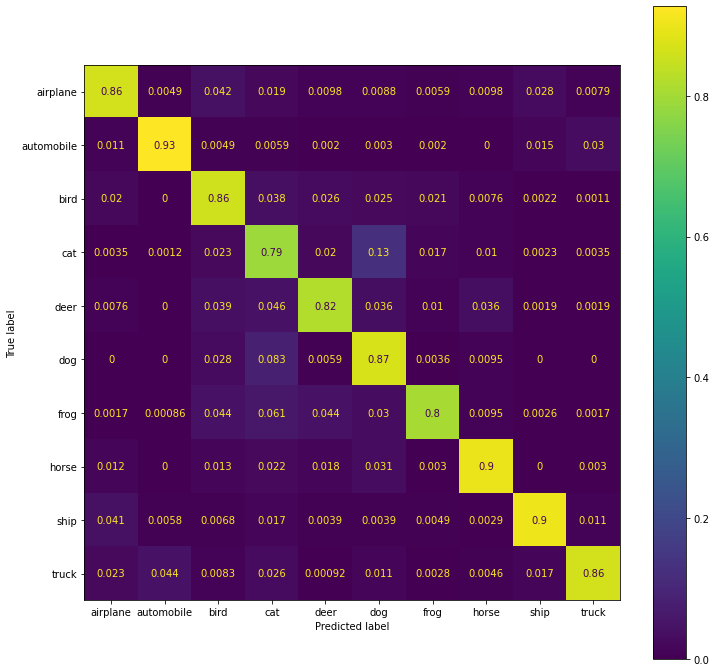

In [170]:
show_confusion_matrix(np.argmax(cnn_5_norm_2_augm.predict(X_test), axis = 1), Y_test, class_labels)

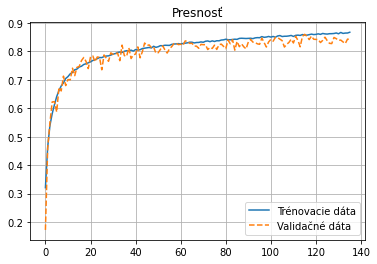

In [163]:
accuracy_plot(cnn_5_norm_2_augm_history)

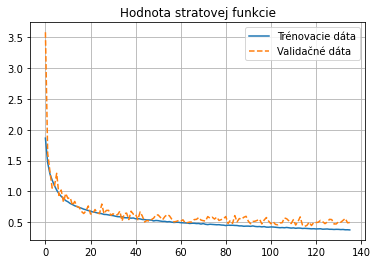

In [164]:
loss_plot(cnn_5_norm_2_augm_history)

In [165]:
cnn_5_norm_2_augm_loss, cnn_5_norm_2_augm_accuracy = cnn_5_norm_2_augm.evaluate(X_test, Y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.4348 - sparse_categorical_accuracy: 0.8600


In [166]:
cnn_5_norm_2_augm_accuracy

0.8600000143051147

Vidíme, že daný model má stále problém so správnou klasifikáciou najmä tried `cat` a `dog` (väčšinou daný model zamieňal klasifikáciu medzi týmito triedami). Istú koreláciu môžeme nájsť aj medzi zámenami iných "zvieracích" tried, avšak po použití augmentácie sa tento problém zmenšil.

Pre ukážku si zobrazíme obrázky z validačného setu a k nim príslušné lable, ktoré predikuje naša natrénovaná CNN sieť:

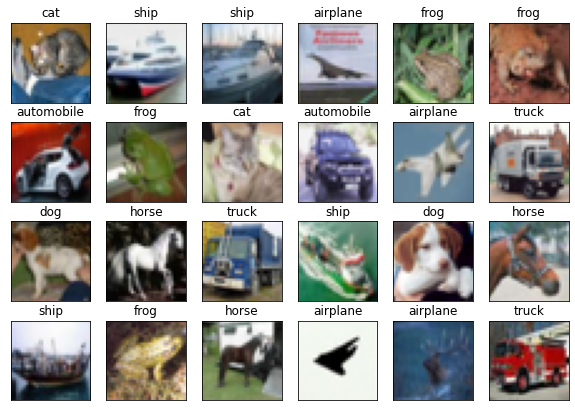

In [168]:
show_images_with_predicted_labels(X_test, np.argmax(cnn_5_norm_2_augm.predict(X_test), axis = 1))

### Záver

Úlohou tejto semestrálnej práce bolo porovnať nekonvolučné a konvolučné siete pri predikovaní tried z CIFAR-10 datasetu. Ako bolo možné vidieť, sieť bez konvolučných vrstiev si neviedla dobre, nakoľko takáto sieť nedokáže dobre extrahovať informácie z okolia jednotlivých pixelov - preto aj pri hľadaní vhodných parametrov pre tento typ siete bol vrátený vysoký počet neurónov spolu s malým batch sizeom, z čoho vyplýva potreba siete čo najviac generalizovať a zapamätať si informácie z trénovacieho datasetu -- dôsledkom je aj rastúci rozdiel v presnosti medzi predikovaním tried z trénovacieho a validačného datasetu už v skorých fázach trénovania.

Pre horeuvedené dôvody som sa rozhodol nepokračovať v snahe vylepšiť jej presnosť. Namiesto toho som sa zameral na siete s konvolučnými vrstvami a snažil sa ich graduálne zlepšiť pomocou rôznych techník v experimentálnej časti tejto semestrálnej práce.

Nakoľko je toto moje prvé stretnutie s neurónovými sieťami všeobence, hodnotím prínos tejto semestrálnej práce za seba ako kladný.

### Referencie

Adam vs. SGD: Closing the generalization gap on image classification - https://opt-ml.org/papers/2021/paper53.pdf


Improvement in Convolutional Neural Network for CIFAR-10 Dataset Image Classification: https://www.ijcaonline.org/archives/volume176/number37/pandit-2020-ijca-920489.pdf


VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION: https://arxiv.org/pdf/1409.1556.pdf